<a href="https://colab.research.google.com/github/AleBoattini/Cartera/blob/main/Desafio_Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduccion
Este modelo esta basado en el desafio de Kaggle, es crear un modelo de prediccion sobre los sobrevivientes del titanic, consta de 1 dataset de entrenamiento y un dataset para la evaluacion.
Link: 

# Diccionario

**PassengerId**: ID

**Survived**: Si sobrevivio o no

**Pclass**: Clase de boleto 1°,2°,3°

**Name**: Nombre de pasajero

**Sex**: Sexo

**Age**: Edad del pasajero

**SibSp**: Nro de hermanos o esposos

**Parch**: Nro de padres o hijos

**Ticket**: Nro de ticket

**Fare**: Tarifa de pasajero

**Cabin**: Nro de cabina

**Embarked**: Puerto de embarque

# Importar DF

Se cargo el dataframe a github para poder ser importado comodamente por url. Aca solo se realiza la carga de ambos dataset

In [155]:
# Librerias Primarias
import pandas as pd
import numpy as np

In [156]:
# Carga de datos

url_test='https://raw.githubusercontent.com/AleBoattini/DATASET/main/TITANIC%20TEST.csv?token=GHSAT0AAAAAAB64OJGVODRGBE7GBW4UXFLOY7TP6KA'
url_train='https://raw.githubusercontent.com/AleBoattini/DATASET/main/TITANIC%20TRAIN.csv?token=GHSAT0AAAAAAB64OJGVHUJHDD3MKZATHLMSY7TP7ZQ'

df_train=pd.read_csv(url_train)
df_test=pd.read_csv(url_test)

# Revision del DF

A continuacion lo que se realizo es la lectura de datos. Los puntos importantes a notar es que faltan datos de edades y embarcacion. 
Como tambien notamos columnas que pueden no ser de utilidad como la de Ticket y Cabina, esta ultima podria dar la ubicacion de los pasajeros en la embarcacion pero tiene mas del 60% de sus datos faltantes por lo solo se conciderara de tener un modelo poco eficiente. 

In [157]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [158]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [159]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [160]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [161]:
df_train.set_index('PassengerId', inplace=True)
df_test.set_index('PassengerId',inplace=True)

## Prediccion de las edades faltantes
Se realiza un modelo de arbol de decisiones para lograr predecir las edades faltantes de los pasajeros, se entrena el modelo con el 90% de los datos y se prueba sobre el 10% restante. 
Lo importante del modelo es que logre aproximar las edades no necesariamente deben ser exactas.

In [162]:
#@title
# Crear las etiquetas para los grupos
def redondear(x):
  bins = [80,70,60,50,40,30,20,15,10,5,0]
  for n in bins:
    if n <= x:
      return n

In [163]:
#@title
# Redondeo la edad hacia abajo

df_train['Age']=np.floor(df_train['Age'])

In [164]:
#@title
# A traves de un arbol de decision completamos las edades faltantes, concidero informacion util para el momento de saber si mueren o sobreviven

#se importa el modulo de interes
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

# Modelado
## Variables de interes

temporal=df_train.dropna(subset=['Age'])

temporal["Sex_bin"] = (temporal["Sex"] == "female").astype(int);
df_train["Sex_bin"] = (df_train["Sex"] == "female").astype(int);
df_test["Sex_bin"] = (df_test["Sex"] == "female").astype(int);

temporal=temporal[['SibSp','Parch','Age','Sex_bin','Fare']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(temporal.drop('Age', axis=1), temporal['Age'], test_size=0.1, random_state=112)

## Cargo modelo
model=DecisionTreeRegressor()
## Entreno
model.fit(X_train1,y_train1)

#Conjunto de datos 
y_pred1=model.predict(X_test1)

# Calculo el % de error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

print("El MAPE es:", mape1, "%")

El MAPE es: 37.486513695908755 %


<ipython-input-164-f6e6fa090ef1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporal["Sex_bin"] = (temporal["Sex"] == "female").astype(int);


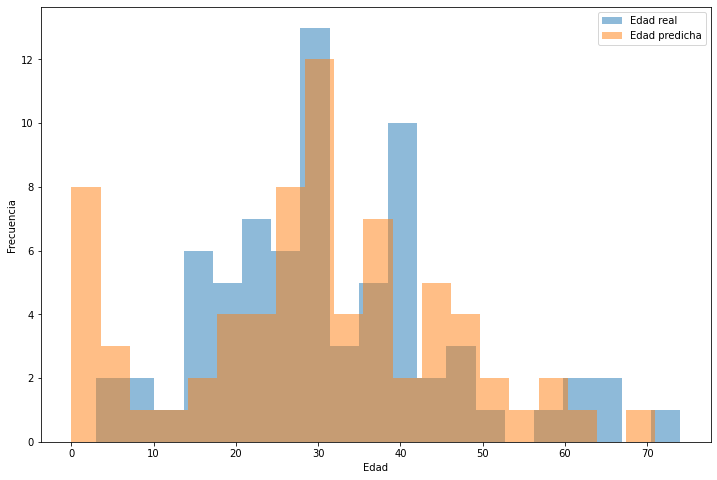

In [165]:
#@title
import matplotlib.pyplot as plt

# Grafica histograma doble
plt.figure(figsize=(12,8))
plt.hist(y_test1, bins=20, alpha=0.5, label='Edad real')
plt.hist(y_pred1, bins=20, alpha=0.5, label='Edad predicha')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right')
plt.show()

### df_train:

In [166]:
# Obtener las filas con valores nulos en la columna 'Age'
null_age = df_train['Age'].isnull()

# Seleccionar las filas con valores nulos y las columnas de interés
x1 = df_train[null_age][['SibSp','Parch','Sex_bin','Fare']]

# Realizar las predicciones con el modelo
y1 = model.predict(x1)
y1=np.floor(y1)

# Asignar los valores predichos en las filas con valores nulos en la columna 'Age'
df_train.loc[null_age, 'Age'] = y1


In [167]:
# Redondeo la nueva edad hacia abajo

df_train['Age']=np.floor(df_train['Age'])

### df_test

In [168]:
# Obtener las filas con valores nulos en la columna 'Age'
null_age2 = df_test['Age'].isnull()

# Seleccionar las filas con valores nulos y las columnas de interés
x2 = df_test[null_age2][['SibSp','Parch','Sex_bin','Fare']]

# Realizar las predicciones con el modelo
y2 = model.predict(x2)
y2=np.floor(y2)

# Asignar los valores predichos en las filas con valores nulos en la columna 'Age'
df_test.loc[null_age2, 'Age'] = y2

## Prediccion de la embarcacion faltante
La embarcacion completamos con su probabilidad mas cercana, dado que son solo 2 datos faltantes no se concidera que afecte al modelo pero no se desea perderlos

In [169]:
df_train[df_train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


In [170]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Arbol para entender la embarcacion

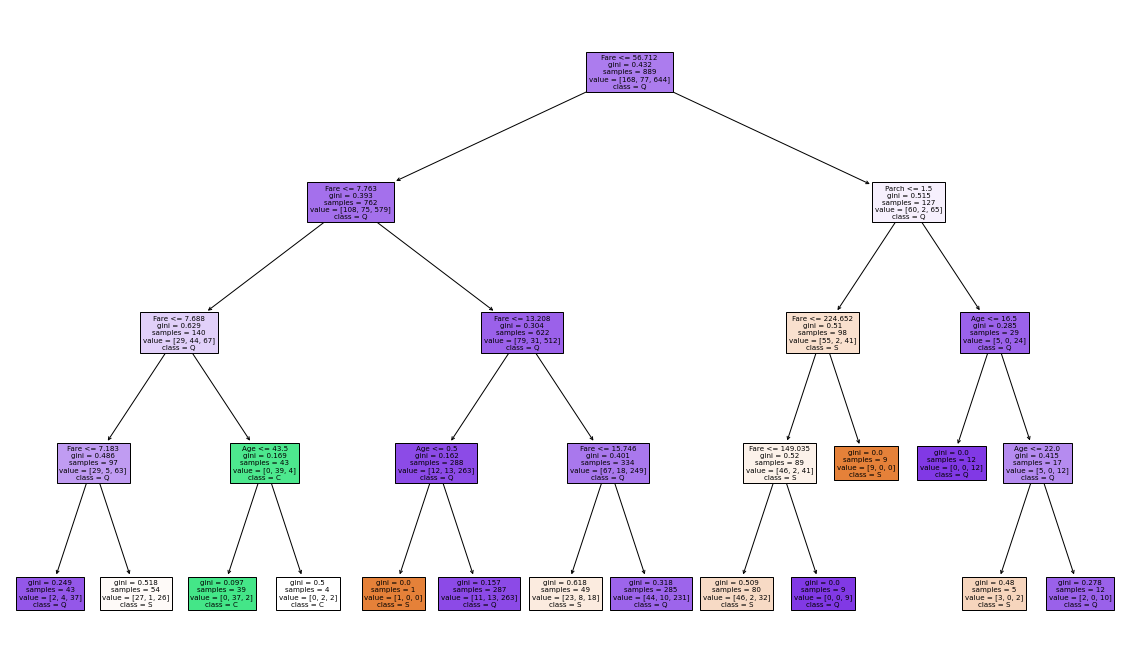

In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

arbol=DecisionTreeClassifier(max_depth=4)

temporal=df_train.dropna(subset=['Embarked'])
x3=temporal[['Survived', 'Sex_bin', 'Fare', 'SibSp', 'Parch','Age']]
y3=temporal['Embarked']

arbol.fit(x3,y3)


plt.figure(figsize=(20,12))
plot_tree(decision_tree=arbol, feature_names=x.columns, class_names=['S','C','Q'], filled=True);


In [172]:
#Relleno la embarcacion con su clase, lo hago manual por solo ser 2 datos de interes. 

null_embarked=df_train['Embarked'].isnull()
df_train[null_embarked]
df_train.loc[null_embarked, 'Embarked']='S'

# Modelo de prediccion
Aca recien se comienza a crear el modelo para la prediccion de los sobrevivientes del titanic, se usa el RandomForestClassifier por ser un modelo de clasificacion y regresion. Y de los que mejor se ajustaron al momento de realizar las pruebas

## Entrenamiento del modelo
Se vuelve a tener al modelo de RandomForestClassifier como de los que mejor se ajustan presentando una precision de aproximadamente 90% en el numero de sobrevivientes

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


df_model=df_train[['Survived', 'Pclass', 'Age','SibSp', 'Parch','Sex_bin']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_model.drop('Survived', axis=1), df_model['Survived'], test_size=0.1, random_state=12222)


# Crear el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=45)

# Entrenar el modelo
model.fit(X_train2, y_train2)

# Realizar predicciones en el conjunto de prueba
y_pred2 = model.predict(X_test2)

# Evaluar la precisión del modelo
accuracy2 = accuracy_score(y_test2, y_pred2)

print("Precisión: {:.2f}%".format(accuracy2 * 100))

Precisión: 88.89%


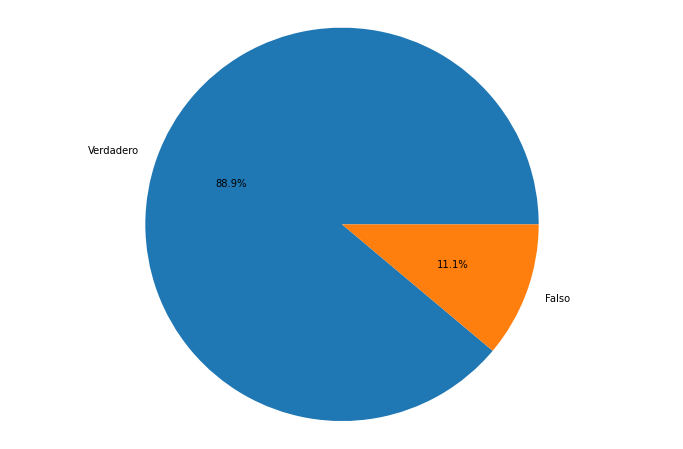

In [174]:
acierto=(y_pred2==y_test2).value_counts()

labels = ['Verdadero', 'Falso']

plt.figure(figsize=(12,8))
plt.pie(acierto, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## Prediccion del modelo para entrega
En la pagina de Kaggle da una precision de acierto del 73%, pareciera haber personas que lograron una prediccion exacta aunque esto es extraño, al ser justamente predicciones podemos acercarnos a la excelencia pero no estar sobre ella. 

In [175]:
x4=df_test[['Pclass', 'Age','SibSp', 'Parch','Sex_bin']]
sobrevivientes=model.predict(x4)
df_test['Survived']=sobrevivientes

In [181]:
Entrega=df_test['Survived']
Entrega.to_csv('Survived.csv', mode='a', header=True, index=True)